In [1]:
# Import required libraries
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from model import DenseNet121, CLASS_NAMES
# encoding: utf-8

"""
Fixed Evaluation Code for CheXNet
"""

import os
import numpy as np
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.models import densenet121
from sklearn.metrics import roc_auc_score
from read_data import ChestXrayDataSet
from tqdm import tqdm  # For progress tracking
# Importing the model and class names from model.py


In [2]:
# Grad-CAM implementation
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None

        # Hooks to save activations and gradients
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activation = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate_heatmap(self, class_idx):
    # Compute the weights
        weights = self.gradients.mean(dim=[0, 2, 3]).to(self.activation.device)  # Ensure weights are on the same device as activation
        activation = self.activation.squeeze(0).detach()

    # Initialize the heatmap on the correct device
        heatmap = torch.zeros(activation.shape[1:], device=activation.device)

    # Compute the weighted sum of activations
        for i, w in enumerate(weights):
            heatmap += w * activation[i]

    # Apply ReLU to remove negative values
        heatmap = torch.clamp(heatmap, min=0)
        return heatmap.cpu().numpy()  # Move to CPU for visualization

In [3]:
 # Path to the pre-trained model checkpoint
N_CLASSES = len(CLASS_NAMES)  # Number of classes

CKPT_PATH = "arnoweng-model.pth.tar"  # Path to the model checkpoint
# Initialize the model
model = DenseNet121(N_CLASSES).cuda()

# Load the checkpoint
checkpoint = torch.load(CKPT_PATH)

# Adjust state_dict to fix keys
state_dict = checkpoint["state_dict"]
new_state_dict = {}
for k, v in state_dict.items():
    # Remove 'module.' prefix if present
    new_key = k.replace("module.", "")
    # Replace 'norm.1' with 'norm1', 'conv.1' with 'conv1', etc.
    new_key = new_key.replace(".1", "1").replace(".2", "2").replace(".3", "3")
    new_state_dict[new_key] = v

# Load the adjusted state_dict
model.load_state_dict(new_state_dict)

# Set model to evaluation mode
model.eval()

print("Model loaded successfully with adjusted state_dict!")


C:\Users\zafer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\zafer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\zafer\AppData\Local\Temp\ipykernel_148\368776349.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses t

Model loaded successfully with adjusted state_dict!


In [4]:
# Identify the target layer for Grad-CAM
target_layer = model.densenet121.features[-1]  # Last convolutional layer of DenseNet121
grad_cam = GradCAM(model, target_layer)


In [5]:
import os
import random

# Paths
test_list_path = "ChestX-ray14/labels/test_list.txt"
image_dir = "C:/Users/zafer/OneDrive/Masaüstü/Dev/cnn-in-nih14-old/dataset/images-1024/images-1024"

# Load test_list.txt and pick a random image
with open(test_list_path, "r") as f:
    lines = f.readlines()

# Extract image IDs
image_ids = [line.split()[0] for line in lines]
random_image_id = random.choice(image_ids)

# Full image path
random_image_path = os.path.join(image_dir, random_image_id)

print(f"Selected random image: {random_image_path}")

# Load test_list.txt and find the labels for the selected image
with open(test_list_path, "r") as f:
    lines = f.readlines()

# Find the corresponding line for the selected image
selected_line = next(line for line in lines if random_image_id in line)

# Extract binary labels for the diseases
binary_labels = list(map(int, selected_line.split()[1:]))

# Map binary labels to disease names
detected_diseases = [CLASS_NAMES[i] for i, label in enumerate(binary_labels) if label == 1]

print(f"Detected diseases for the image '{random_image_id}': {detected_diseases}")


Selected random image: C:/Users/zafer/OneDrive/Masaüstü/Dev/cnn-in-nih14-old/dataset/images-1024/images-1024\00004613_008.png
Detected diseases for the image '00004613_008.png': []


In [6]:
# Best thresholds
best_thresholds = [
    0.66,  # Atelectasis
    0.71,  # Cardiomegaly
    0.66,  # Effusion
    0.63,  # Infiltration
    0.70,  # Mass
    0.69,  # Nodule
    0.69,  # Pneumonia
    0.69,  # Pneumothorax
    0.67,  # Consolidation
    0.70,  # Edema
    0.71,  # Emphysema
    0.72,  # Fibrosis
    0.69,  # Pleural_Thickening
    0.71   # Hernia
]

In [7]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to model's input size
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize
])

In [8]:
def process_image(image_input):
    """
    Processes the image for model input.
    Args:
        image_input: Path to the image file (string) or a PIL Image object.
    Returns:
        input_tensor: Processed tensor ready for the model.
        image: Original PIL Image object for visualization.
    """
    if isinstance(image_input, str):  # If input is a file path
        image = Image.open(image_input).convert('RGB')  # Ensure 3-channel RGB
    elif isinstance(image_input, Image.Image):  # If input is already a PIL Image
        image = image_input
    else:
        raise ValueError("Unsupported image input type. Provide a file path or PIL Image.")

    input_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    return input_tensor, image

# Predict diseases from the image
def predict_diseases(model, input_tensor):
    device = next(model.parameters()).device  # Ensure model device (CPU or GPU)
    input_tensor = input_tensor.to(device)  # Move input to the same device as the model
    with torch.no_grad():
        logits = model(input_tensor)
        probabilities = torch.sigmoid(logits).squeeze().cpu().numpy()
    return probabilities


# Display predictions
def display_predictions(image_path, probabilities):
    # Filter predictions based on thresholds
    detected_diseases = [
        f"{CLASS_NAMES[i]} ({probabilities[i]:.2%})"
        for i in range(len(CLASS_NAMES))
        if probabilities[i] > best_thresholds[i]
    ]
    detected_text = "\n".join(detected_diseases) if detected_diseases else "No diseases detected."

    print(f"\nUploaded Image: {os.path.basename(image_path)}")
    print(f"Predictions:\n{detected_text}")


In [9]:
def grad_cam_on_predictions(model, input_tensor, original_image, class_names, thresholds):
    """
    Generate Grad-CAM visualizations for diseases predicted by the model and plot prediction scores with thresholds.
    Args:
        model: The trained model.
        input_tensor: The input tensor for the image.
        original_image: The original uploaded image (PIL format).
        class_names: List of class names.
        thresholds: List of thresholds for each class.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from PIL import Image

    # Ensure input tensor is on the same device as the model
    device = next(model.parameters()).device
    input_tensor = input_tensor.to(device)

    # Get raw logits and predictions
    logits = model(input_tensor)  # Raw output from the model
    probabilities = torch.sigmoid(logits).detach().cpu().numpy().flatten()  # Sigmoid for multi-label probabilities

    # Filter predictions based on thresholds
    predicted_indices = [i for i in range(len(class_names)) if probabilities[i] > thresholds[i]]
    predicted_scores = [probabilities[i] for i in predicted_indices]
    predicted_classes = [class_names[i] for i in predicted_indices]

    # Grad-CAM visualization
    if predicted_classes:
        # Create subplots for the original image and Grad-CAM overlays
        fig, axes = plt.subplots(1, len(predicted_classes) + 1, figsize=(6 * (len(predicted_classes) + 1), 6))

        # Plot the original image in the first column
        axes[0].imshow(original_image)
        axes[0].set_title("Original Image", fontsize=14)
        axes[0].axis("off")

        # Grad-CAM overlays for each predicted disease
        for idx, (disease, score) in enumerate(zip(predicted_classes, predicted_scores)):
            target_class = class_names.index(disease)

            # Generate Grad-CAM heatmap for the specific target class
            model.zero_grad()  # Clear existing gradients
            logits[0, target_class].backward(retain_graph=True)  # Retain the computational graph
            heatmap = grad_cam.generate_heatmap(target_class)  # Assuming grad_cam is initialized
            heatmap = np.maximum(heatmap, 0)
            heatmap /= heatmap.max()

            # Resize and blend heatmap with the original image
            heatmap_resized = Image.fromarray((heatmap * 255).astype(np.uint8)).resize(original_image.size, Image.BICUBIC)
            heatmap_array = np.array(heatmap_resized)
            heatmap_overlay = np.array(original_image).astype(np.float32)
            heatmap_overlay = (
                heatmap_overlay * 0.6 + plt.cm.jet(heatmap_array / 255.0)[:, :, :3] * 255 * 0.4
            ).astype(np.uint8)

            # Plot Grad-CAM overlay with confidence percentage
            axes[idx + 1].imshow(heatmap_overlay)
            axes[idx + 1].set_title(f"{disease}\nConfidence: {score:.2%}")
            axes[idx + 1].axis("off")

        plt.tight_layout()
        plt.show()
    else:
        print("No predictions above thresholds for Grad-CAM visualization.")

    # Bar Chart for All Predictions
    fig, ax = plt.subplots(figsize=(12, 8))
    bars = ax.bar(
        class_names, 
        probabilities, 
        color=['green' if probabilities[i] > thresholds[i] else 'red' for i in range(len(class_names))]
    )

    # Add threshold lines
    for i, threshold in enumerate(thresholds):
        ax.plot(
            [i - 0.4, i + 0.4],  # X-range for each threshold line
            [threshold, threshold], 
            color='blue', 
            linestyle='--', 
            linewidth=1,
            label=f'{class_names[i]} Threshold' if i == 0 else None  # Add label only once for the legend
        )

    ax.set_title("Disease Prediction Confidence Scores with Thresholds", fontsize=16)
    ax.set_xlabel("Diseases", fontsize=14)
    ax.set_ylabel("Confidence Score", fontsize=14)
    ax.set_ylim(0, 1)
    ax.set_xticks(range(len(class_names)))
    ax.set_xticklabels(class_names, rotation=45, ha='right')
    plt.legend(["Thresholds", "Predictions"], loc="upper right")
    plt.tight_layout()
    plt.show()


In [10]:
import requests
from io import BytesIO
from PIL import Image
import os

def download_image_from_url(image_url):
    """
    Downloads an image from the given URL and returns it as a PIL Image object.
    """
    try:
        # Add headers to mimic a browser request
        headers = {
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
            "Referer": image_url  # Sometimes adding the referer helps
        }
        response = requests.get(image_url, headers=headers, stream=True)
        response.raise_for_status()  # Raise HTTPError for bad responses (4xx, 5xx)
        
        # Open the image
        return Image.open(BytesIO(response.content)).convert("RGB")
    except requests.exceptions.HTTPError as e:
        print(f"HTTP Error: {e}")
    except requests.exceptions.ConnectionError as e:
        print(f"Connection Error: {e}")
    except Exception as e:
        print(f"Error downloading the image: {e}")
    return None

def main(model):
    # Prompt user for image path or URL
    image_path = input("Enter the full path to your image or a web link: ")

    if image_path.startswith("http://") or image_path.startswith("https://"):
        # Handle web URL
        image = download_image_from_url(image_path)
        if image is None:
            return None, None
        input_tensor, original_image = process_image(image)
    elif os.path.exists(image_path):
        # Handle local file
        try:
            input_tensor, original_image = process_image(image_path)
        except Exception as e:
            print(f"Error processing the local image: {e}")
            return None, None
    else:
        print(f"Error: The file '{image_path}' does not exist or is not a valid URL.")
        return None, None

    # Predict diseases
    probabilities = predict_diseases(model, input_tensor)

    # Display results
    display_predictions(image_path, probabilities)

    # Return inputs for Grad-CAM
    return input_tensor, original_image



Uploaded Image: 6f63736ff837ff7c5a736b35aba6ab_big_gallery.jpeg
Predictions:
Cardiomegaly (73.09%)
Pleural_Thickening (69.28%)

Generating Grad-CAM for predictions...


C:\Users\zafer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


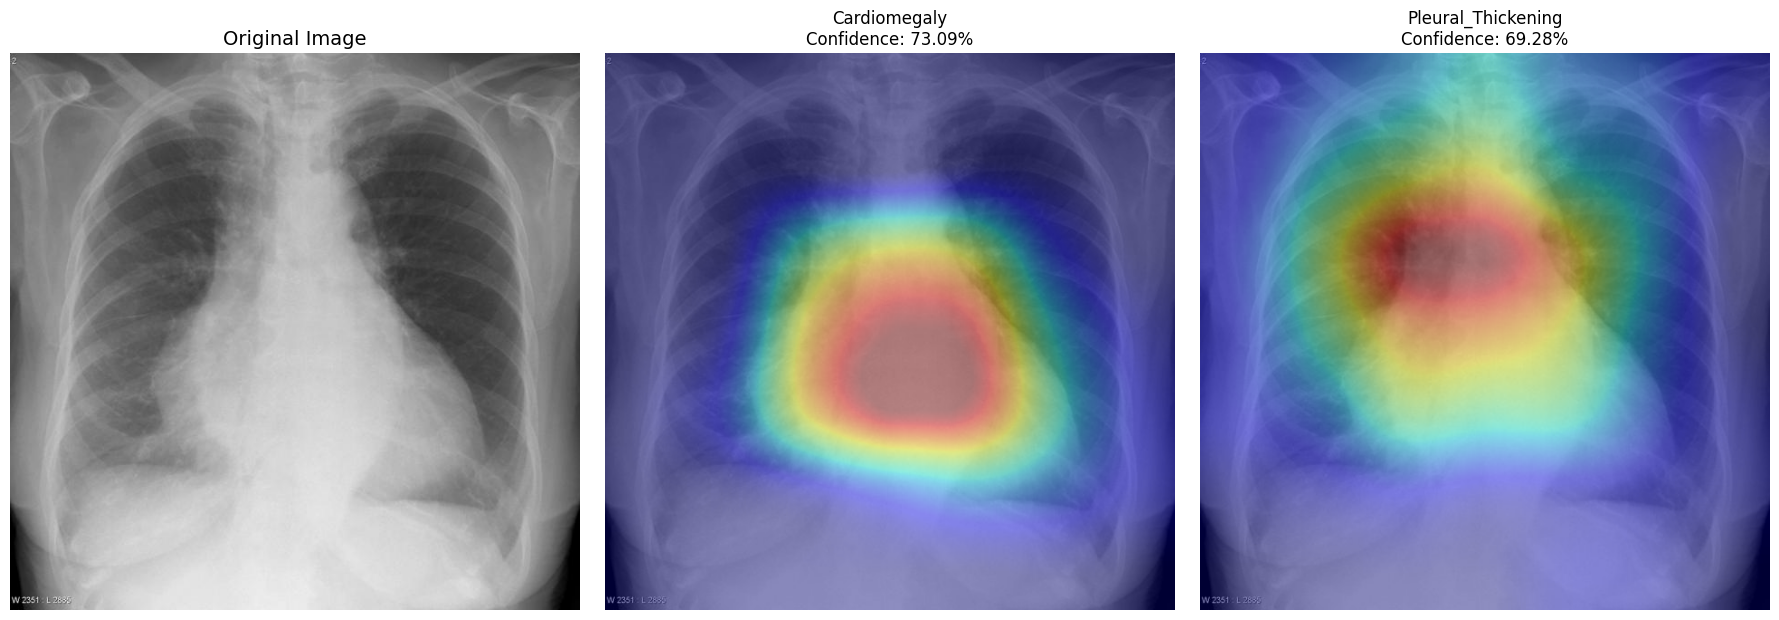

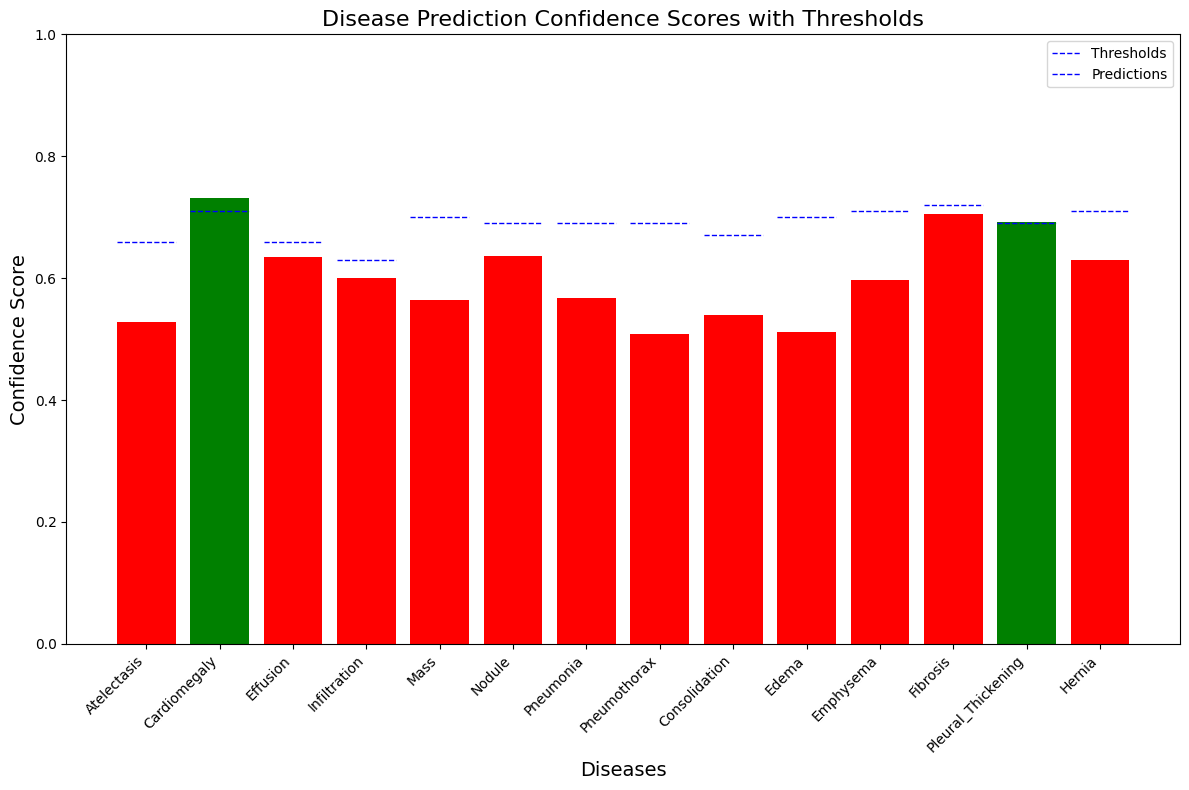

In [12]:
input_tensor, original_image = main(model)  # Run main and get the tensor and image
if input_tensor is not None and original_image is not None:
    print("\nGenerating Grad-CAM for predictions...")
    grad_cam_on_predictions(model, input_tensor, original_image, CLASS_NAMES, best_thresholds)
